# Pytorch Model (additional, not necessary for thesis)

In [833]:
# imports
import numpy as np
import pandas as pd
import time
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch import nn
from sklearn.preprocessing import StandardScaler

In [834]:
probabilities = pd.read_csv('files/switzerland_probabilities.csv').drop(columns=["Name_de","Berufshauptgruppe"])
df = pd.read_csv('files/switzerland_occupations.csv')

In [835]:
df = df.merge(probabilities, on='isco08')
df.head(5)

isco08       Name_de  Berufshauptgruppe    s1    s2    s3    s4    s5  \
0    2655  Schauspieler                  2  0.72  0.72  0.69  0.69  0.50   
1    2612       Richter                  2  0.81  0.75  0.81  0.72  0.81   
2    2612       Richter                  2  0.81  0.75  0.81  0.72  0.81   
3    2612       Richter                  2  0.81  0.78  1.00  0.75  0.97   
4    2612       Richter                  2  0.81  0.78  1.00  0.75  0.97   

     s6    s7  ...   a44  a45  a46  a47   a48   a49  a50  a51  a52  \
0  0.50  0.50  ...  0.00  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0   
1  0.66  0.56  ...  0.31  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0   
2  0.66  0.56  ...  0.31  0.0  0.0  0.0  0.00  0.00  0.0  0.0  0.0   
3  0.72  0.60  ...  0.28  0.0  0.0  0.0  0.03  0.03  0.0  0.0  0.0   
4  0.72  0.60  ...  0.28  0.0  0.0  0.0  0.03  0.03  0.0  0.0  0.0   

   probability  
0       0.9992  
1       0.9959  
2       0.8960  
3       0.9959  
4       0.8960  

[5 rows x 91 columns]

In [836]:
a_cols = df.columns[df.columns.str.startswith('a')].shape[0]
s_cols = df.columns[df.columns.str.startswith('s')].shape[0]

total_inputs = a_cols + s_cols
print(f"Total inputs: {total_inputs}")

Total inputs: 87


In [837]:
## Global settings
# Train/validation/test split: 80% train, 10% validation, 10% testsplit
split_size = (0.8, 0.1, 0.1)

# Dropout rate: 5%
dropout_rate = 0.05

# Batch import size: 10 jobs in a minibatch
batch_size = 20

# Number of epochs
num_epochs = 100

# Define L2 regularization strength (penalty parameter)
l2_reg = 0.01

# Early stopping parameters
early_stopping = False

# Initial best loss set to infinity
best_val_loss = float('inf')

# Number of epochs with no improvement to wait before stopping
patience = 10

# Counter for epochs without improvement
no_improve_epochs = 0

In [838]:
class TabularDataset(Dataset):
    def __init__(self, df, target_col, ignore_cols):
        self.data = df.drop(columns=ignore_cols).copy()
        self.target_col = target_col

        # Standardize the features
        scaler = StandardScaler()
        self.data.loc[:, self.data.columns != target_col] = scaler.fit_transform(self.data.loc[:, self.data.columns != target_col])

        # Create targets tensor
        self.targets = torch.tensor(self.data.loc[:, target_col].values, dtype=torch.float)

        # Convert data to tensor
        self.data = torch.tensor(self.data.drop(columns=target_col).values, dtype=torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx, :], self.targets[idx]

# Specify columns to ignore
ignore_cols = ["Name_de", "isco08", "Berufshauptgruppe"]

# Load data
dataset = TabularDataset(df, 'probability', ignore_cols)

# Visualize one sample
print(dataset[0])

(tensor([ 0.4328,  0.3098,  0.1594,  1.4569, -1.6009, -1.1263, -0.4327, -1.0535,
        -0.7410, -1.1766, -0.8552, -0.5559, -0.4866, -1.2700, -0.3694, -0.6579,
        -0.6379, -1.8697, -1.7147, -1.5923, -0.7181, -0.7665, -1.5438, -1.5015,
        -0.7709, -0.9134, -0.4617, -1.9087, -2.4560, -2.7706, -1.1889, -1.6982,
        -1.8765, -0.7386, -1.1687,  0.5296,  0.5033,  3.8244,  0.6601,  0.3406,
         1.9237,  0.0165, -1.3340,  0.0395, -0.0611, -1.2641, -1.8626, -1.5750,
        -1.5187, -1.0293, -1.3460,  0.6005, -0.0929, -1.6246,  0.1910, -1.7544,
         0.9569, -0.9602, -0.2806, -0.7077,  0.5222,  0.1943, -0.6314,  0.6476,
        -0.2116, -0.0631, -1.7075,  0.4183,  0.1693, -0.8878,  0.9278, -0.6914,
         0.3330, -2.8100, -1.3642, -1.2370, -1.7740, -0.4514, -2.7840, -0.7725,
        -0.7862, -0.9453, -1.0205, -0.9964, -0.7923, -0.8850, -0.7978]), tensor(0.9992))


In [839]:
# Prepare the data
feature_cols = [col for col in df.columns if col.startswith(('s', 'a'))]
X = df[feature_cols]
y = df['probability']

# Create dataset
ignore_cols = ["Name_de", "isco08", "Berufshauptgruppe"]
dataset = TabularDataset(df, 'probability', ignore_cols)

# Define split sizes
split_size = (0.8, 0.1, 0.1)
train_size = int(split_size[0] * len(dataset))
val_size = int(split_size[1] * len(dataset))
test_size = len(dataset) - train_size - val_size

# Randomly split dataset into train, validation and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(f'Training: {len(train_dataset)}, validation: {len(val_dataset)}, test: {len(test_dataset)}')

# Define batch size
batch_size = 10

# Create data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

Training: 3566, validation: 445, test: 447


In [840]:
class pytorch_probabilities(nn.Module):
    def __init__(self):
        super(pytorch_probabilities, self).__init__()
        # The architecture of the neural network is based on the following paper:
        # Yar Muhammad, Mohammad Dahman Alshehri, Wael Mohammed Alenazy, Truong Vinh Hoang, Ryan Alturki
        # "Identification of Pneumonia Disease Applying an Intelligent Computational Framework Based on Deep Learning and Machine Learning Techniques", Mobile Information Systems, vol. 2021, Article ID 9989237, 20 pages, 2021. https://doi.org/10.1155/2021/9989237

        # The architecture consists of a convolutional layer, a pooling layer, and a fully connected layer.
        # The convolutional layer consists of two convolutional layers.
        # That layer is then ran through a max-pooling layer.
        # Finally, classification is done by a fully connected layer consisting of two linear layers.
        # Dropout is performed both in the convolutional layer and the fully connected layer in order to increase the generalization of the model.

        # Convolutional layer: 2 layers with 32 filters each
        self.fc1 = nn.Linear(87, 87)  # 87 input features, 50 output features
        self.fc2 = nn.Linear(87, 2)  # 250 input features, 125 output features
        self.softmax = nn.Softmax(dim=1)

        # Activation functions
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.batch_norm1 = nn.BatchNorm1d(87)

        # Validation criterion
        self.criterion = nn.CrossEntropyLoss()

    # Forward pass through the network
    def forward(self, x):
        # Pass input through first fully connected layer
        x = self.fc1(x)

        # Apply batch normalization
        x = self.batch_norm1(x)

        # Pass through second fully connected layer
        x = self.fc2(x)

        # Apply softmax activation function
        x = self.softmax(x)

        return x
    
    # Validate model on dataset
    def validate(self, loader):
        # Set to evaluation mode
        self.eval()

        correct, total = 0, 0

        with torch.no_grad():
            # Track loss values
            losses = []

            for data, targets in loader:
                # Generate predictions
                outputs = self(data)

                # Predict validation data
                _, predicted = torch.max(outputs.detach(), dim=1)

                total += targets.size(0)
                correct += ((predicted - targets).abs() <= 0.05).sum().item()

                # Calculate and track loss for predictions outside the range
                out_of_range = (predicted - targets).abs() > 0.05
                if out_of_range.any():
                    losses.append(self.criterion(outputs[out_of_range], targets[out_of_range].long()).item())

            # Calculate loss and accuracy
            loss = np.mean(losses) if losses else 0
            accuracy = 100 * correct / total

            return loss, accuracy

In [841]:
# Instantiate the model
model = pytorch_probabilities()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Keep track of losses per epoch
train_losses = []
validation_losses = []

# Keep track of epoch start/end times
start_time, end_time = None, None

# Train model
for epoch in range(num_epochs):
    # Start timer
    start_time = time.perf_counter()

    # Set model to training mode
    model.train()

    # Track loss values (inside epoch)
    losses = []

    # Train model on training data
    for data, targets in train_loader:
        # Reset gradients
        optimizer.zero_grad()

        # Generate predictions
        outputs = model(data)

        # Calculate and track loss
        loss = criterion(outputs, targets.long())
        losses.append(loss.item())

        # Regularization using L2 norm
        l2_loss = 0
        for param in model.parameters():
            l2_loss += torch.norm(param, p=2)**2

        loss += l2_reg * l2_loss

        losses.append(loss.item())

        # Back-propagate loss
        loss.backward()

        # Update weights
        optimizer.step()
        
        # Print predictions and targets
        _, predicted = torch.max(outputs, 1)
        print(f'Predicted: {predicted}, Targets: {targets}')

    # End timer
    end_time = time.perf_counter()

    train_losses.append(np.mean(losses))

    # Evaluate model on validation data
    val_loss, val_accuracy = model.validate(val_loader)

    validation_losses.append(val_loss)

    # Print summary each epoch
    print(f'Epoch: {epoch + 1}/{num_epochs} (train_loss: {np.mean(losses):.2f}, val_loss: {val_loss:.2f}, accuracy: {val_accuracy:.2f}%, time: {end_time - start_time:.2f}s))')

    # Stop early if validation loss does not improve anymore
    if early_stopping:
        current_val_loss = val_loss

        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss

            # Save best model
            torch.save(model.state_dict(), f'pytorch_model/calculate_probability.pth')

            # Reset counter
            no_improve_epochs = 0
        else:
            # Increase counter
            no_improve_epochs += 1

        # Stop training if patience is exceeded
        if no_improve_epochs >= patience:
            print("Early stopping due to no improvement.")
            break
    else:
        # Save model weights (each epoch)
        torch.save(model.state_dict(), f'pytorch_model/calculate_probability.pth')

Predicted: tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0]), Targets: tensor([0.9566, 0.9821, 0.8083, 1.0000, 0.9991, 0.9745, 0.9959, 0.9994, 0.9915,
        0.9983])
Predicted: tensor([1, 0, 0, 1, 0, 1, 0, 0, 1, 1]), Targets: tensor([1.0000, 1.0000, 0.9959, 0.9814, 0.9934, 0.9957, 0.9995, 0.8083, 1.0000,
        0.2217])
Predicted: tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0]), Targets: tensor([0.9998, 1.0000, 0.9973, 1.0000, 0.9887, 0.9726, 1.0000, 0.9882, 0.9947,
        0.9917])
Predicted: tensor([0, 1, 1, 1, 0, 1, 1, 0, 0, 1]), Targets: tensor([0.9960, 1.0000, 0.9602, 1.0000, 0.9993, 1.0000, 1.0000, 0.9996, 0.9959,
        0.9968])
Predicted: tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0]), Targets: tensor([1.0000, 1.0000, 0.9999, 0.9860, 0.9941, 1.0000, 0.9985, 0.9992, 0.9993,
        0.9762])
Predicted: tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0]), Targets: tensor([0.7061, 1.0000, 0.9968, 0.9742, 0.9999, 0.8083, 0.9478, 0.9895, 0.9951,
        0.9301])
Predicted: tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1]), Targets

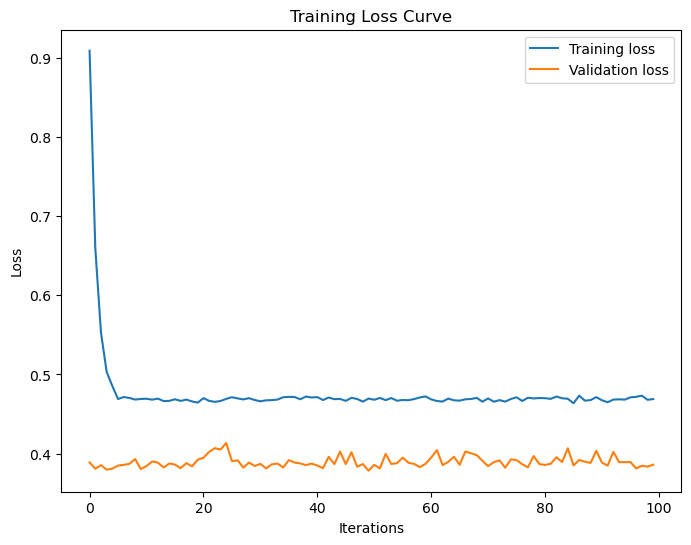

In [842]:
## Plot the training and validation losses (Dries)
plt.figure(figsize=(8, 6))

plt.plot(range(len(train_losses)), train_losses, label="Training loss")
plt.plot(range(len(validation_losses)), validation_losses, label="Validation loss")

plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.title('Training Loss Curve')

plt.legend()

plt.show()

In [843]:
## Evaluate the final model (Florian)
# Load the saved model
model = pytorch_probabilities()
model.load_state_dict(torch.load('pytorch_model/calculate_probability.pth'))

# Evaluate the model on the test data
test_loss, test_accuracy = model.validate(test_loader)

# Print summary
print(f'Test loss: {test_loss:.2f}, test accuracy: {test_accuracy:.2f}%')

Test loss: 0.39, test accuracy: 15.21%
